In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

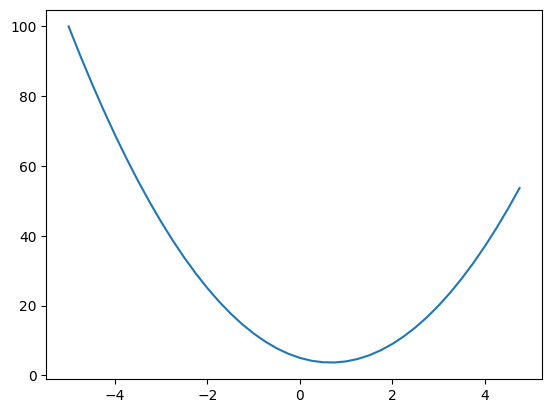

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

d(f(x))/dx means

lim h--> 0 { (f(x+h) - f(x)) / h }

*It basically means the change in the output of function if there is very slight change in input value*

In [5]:
# differentiation of fx
h = 0.0000001
x = 2/3

(f(x+h) - f(x))/h

2.9753977059954195e-07

In [6]:
# try with complex one
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

d1 = a*b + c

a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
# change in d if a is changed very slightly
slope = (d2 - d1) / h
print('slope: ', slope)

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [8]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
# change in d if b is changed very slightly
slope = (d2 - d1) / h
print('slope: ', slope)

d1:  4.0
d2:  4.0002
slope:  2.0000000000042206


In [9]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

c += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
# change in d if b is changed very slightly
slope = (d2 - d1) / h
print('slope: ', slope)

d1:  4.0
d2:  4.0001
slope:  0.9999999999976694


In [10]:
# data structure container
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) # to store the intermidiate results of the bigger operation
        self._op = _op # to know which operation caused that intermidiate result
        self.label = label

    # representation container
    # if not defined then it will show memory location like <__main__.Value at 0x788a537fe810>
    def __repr__(self):
        return f"Value(data={self.data})"

    # arithmetic operation
    def __add__(self, other):
        output = Value(self.data + other.data, (self, other), '+')
        return output

    def __mul__(self, other):
        output = Value(self.data * other.data, (self, other), '*')
        return output


In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'

d = e + c # internally - (a.__mul__(b)).__add__(c)
d.label = 'd'
d

Value(data=4.0)

In [12]:
# visual representation to see the series of operations
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set() # set of all nodes and edges
    def build(v):
        if v not in nodes: # check each node
            nodes.add(v)
            # connect every child which involved 'v' for that operation 
            # and connect them with an edge
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': "LR"}) # left -> right (flow)

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n)) # for unique identification of each node
        # for any value in graph, create rectangular(record) node for it
        dot.node(name = uid, label="{ %s | data %.4f} | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation then create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

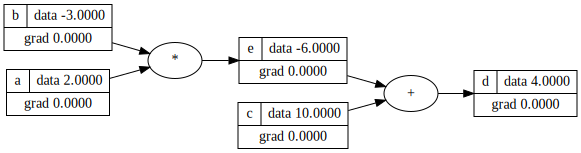

In [13]:
draw_dot(d)

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'

d = e + c # internally - (a.__mul__(b)).__add__(c)
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

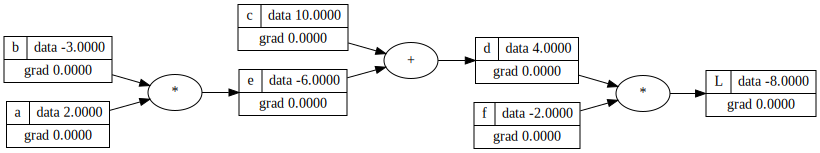

In [15]:
draw_dot(L)

In [16]:
def test():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0+h, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)

test()

-1.9999999999988916


In [17]:
# that means L.grad = 1
L.grad = 1.0

In [18]:
# now dL/dd = f
# similaryly dL/df = d

d.grad = -2.0
f.grad = 4.0

now dL/dc = dL/dd * dd/dc  
dd/dc = 1 ( since d = c + e)  

d = c + e

- (f(x+h) - f(x)) / h
- ((c + h + e) - (c + e)) / h
- (c + h + e - c - e ) / h
- h/h = 1.0

Similarly dd/de = 1.0

Applying chain rule,  
we have dd/dc (1.0) and dL/dd  (-2.0)
given that dL/dc = dL/dd * dd/dc
- dL/dc = (-2.0)*(1.0)
- dL/dc = -2.0

In similary way dL/de = -2.0

In [19]:
c.grad = -2.0
e.grad = -2.0

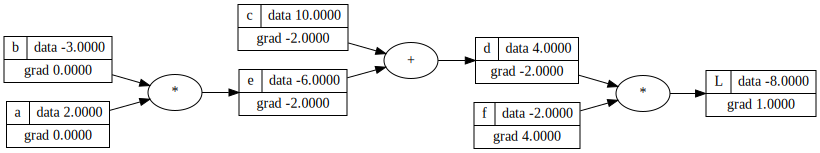

In [20]:
draw_dot(L)